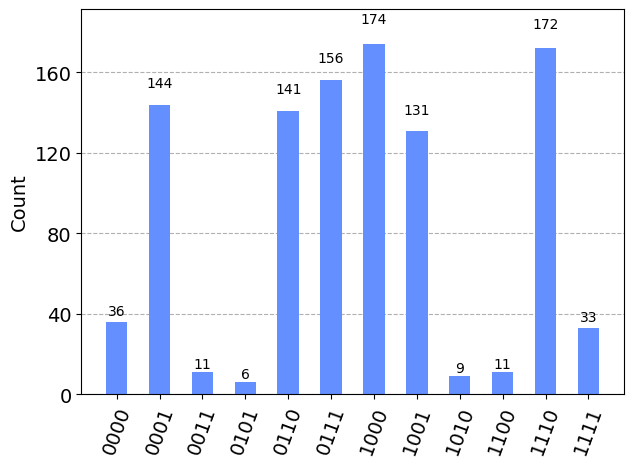

In [116]:
##casual maxcut by qiskit
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import numpy as np

#G = nx.Graph()
#x = [0, 1, 2, 3]
#G.add_nodes_from(x)
#G.add_edges_from([(0, 1), (0, 3), (2, 3)])
#nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

A_m2 = np.array([[1,1],[-4,1]])
G,pos = convert_to_bipartite(A_m2)

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 6

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes_1 = list(range(0,n))
    nodes_2 = list(range(n,2*n))
    bip.add_nodes_from(nodes_1,bipartite=0)
    bip.add_nodes_from(nodes_2,bipartite=1)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n])
    
    pos = nx.bipartite_layout(bip,nodes_1)
    return bip,pos

def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    edge_weights = nx.get_edge_attributes(G, 'weight')
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= edge_weights[(i,j)]
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    edge_weights = nx.get_edge_attributes(G, 'weight')
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * edge_weights[pair]*gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')

from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)
    

Graph with 4 nodes and 4 edges


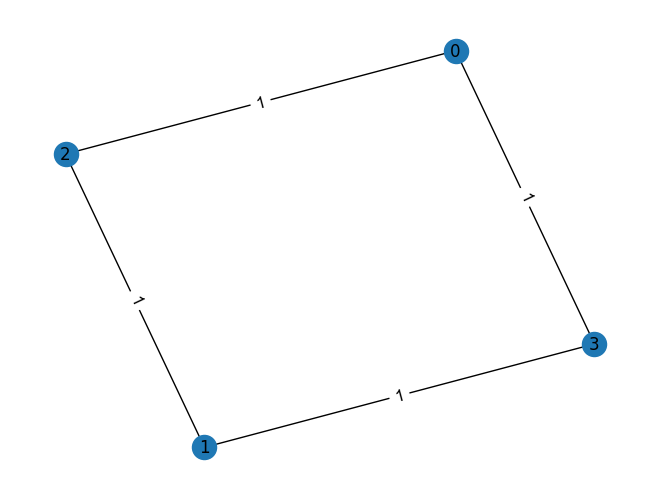

In [50]:
##casual maxcut by qiskit
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import numpy as np


def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes = list(range(0,2*n))
    bip.add_nodes_from(nodes)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n].astype(int))
    return bip

A_m1 = np.array([[1,1],[1,1]])
G = convert_to_bipartite(A_m1)
print(G)
#nx.draw(G, with_labels=True, alpha=0.8, node_size=500)
# Draw the nodes, edges, and labels
edge_labels = nx.get_edge_attributes(G, 'weight')

# Draw graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_family='Arial')

# Show plot
plt.show()

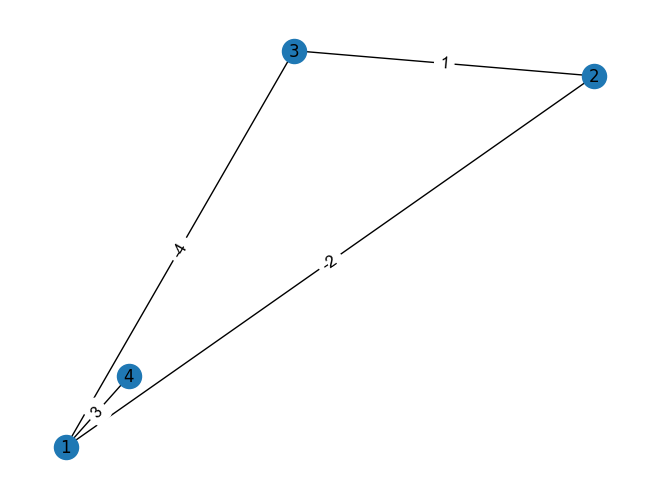

[(1, 2), (1, 3), (1, 4), (2, 3)]


In [97]:
###draw graph with negativ e edge weights
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add edges to the graph with negative weights
G.add_weighted_edges_from([(1, 2, -2), (2, 3, 1), (3, 1, -4), (1, 4, 3)])

# Define the layout of the graph
#pos = nx.spring_layout(G)

edge_labels = nx.get_edge_attributes(G, 'weight')

# Draw graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_family='Arial')

# Show plot
plt.show()

print(G.edges)

{(0, 2): 1, (0, 3): 1, (1, 2): 1, (1, 3): 0}
{0: array([-1.  , -0.75]), 1: array([-1.  ,  0.75]), 2: array([ 1.  , -0.75]), 3: array([1.  , 0.75])}


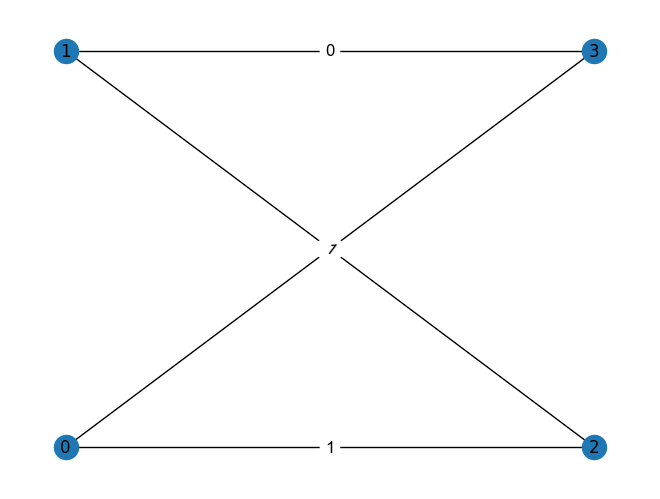

In [101]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes_1 = list(range(0,n))
    nodes_2 = list(range(n,2*n))
    bip.add_nodes_from(nodes_1,bipartite=0)
    bip.add_nodes_from(nodes_2,bipartite=1)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n])
    
    pos = nx.bipartite_layout(bip,nodes_1)
    return bip,pos

A_m2 = np.array([[1,1],[1,0]])
G,pos = convert_to_bipartite(A_m2)
# Get edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
print(edge_labels)
nx.draw(G, pos, with_labels=True)
print(pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_family='Arial')

# Show plot
plt.show()